# パッケージ


In [1]:
import pandas as pd
import datetime
import re
import os
from tqdm import tqdm
import category_encoders as ce
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler

import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# データ加工(データフレーム内)


## one-hot-encoding のモデル作成


### データの整形を行うクラス(ダミー変数化はまだのため仮)


In [69]:
class HorseProcessor:
    def remove_str(x: any) -> str:
        """文字列を抽出する
        Args:
            x (any): 文字列
        Returns:
            str: 抽出した文字列
        """
        x_str = str(x)
        is_contain_num = re.search(r"\d+", x_str)
        if is_contain_num:
            return is_contain_num.group()
        else:
            return "0"

    def convert_date(x: str | int) -> int:
        """日付をその年の1日1月を基点とした日数に変換する
        Args:
            x (str | int): 日付(YYYY/MM/DD)
        Returns:
            int: 日数
        """
        """日付を変換して、その年の1月1日からの週数を計算する"""
        # 日付の形式を変換
        date_converted = datetime.datetime.strptime(x, "%Y/%m/%d")
        # その年の1月1日を計算
        base_date = datetime.datetime(date_converted.year, 1, 1)
        # 週数の差を計算
        return (date_converted - base_date).days // 7

    @staticmethod
    def transform_held(held: str) -> str:
        """開催地を変換する
        Args:
            held (str): 開催地
        Returns:
            str: 開催地の名前
        """
        trim_held = re.sub(r"\d*", "", held)
        if not trim_held in [
            "東京",
            "中山",
            "中京",
            "阪神",
            "札幌",
            "函館",
            "福島",
            "新潟",
            "京都",
            "小倉",
        ]:
            return "その他"
        return trim_held

    @staticmethod
    def transform_race_name(race: str) -> str:
        """レース名を変換する
        Args:
            race (str): レース名
        Returns:
            str: 変換後のレース名
        """
        # r"新馬|未勝利|1勝|2勝|3勝|オープン"
        if re.search(r".*(新馬|未勝利|1勝|2勝|3勝|OP|G1|G2|G3|L).*", race):
            transform_name = re.sub(
                r".*(新馬|未勝利|1勝|2勝|3勝|OP|G1|G2|G3|L).*", r"\1", race
            )
        else:
            transform_name = "その他"
        return transform_name

    @staticmethod
    def extract_addition(df: pd.DataFrame) -> pd.DataFrame:
        """体重の増減を抽出する
        Args:
            df (pd.DataFrame): 変化対象のデータ
        Returns:
            pd.DataFrame: 変換後のデータ
        """
        weight = df["馬体重"]
        addition = weight.map(lambda x: re.sub(r".*\(([+-]\d{1,3}|0)\).*", r"\1", x))
        addition = addition.map(lambda x: re.sub(r"\+", "", x))
        return addition

    @staticmethod
    def drop_columns(df: pd.DataFrame) -> pd.DataFrame:
        """不要なカラムを削除
        Args:
            df (pd.DataFrame): 成績データ
        Returns:
            pd.DataFrame: 削除後データ
        """
        df_processed = df.drop(
            [
                "賞金",
                "厩舎ｺﾒﾝﾄ",
                "備考",
                "勝ち馬(2着馬)",
                "着差",
                "ﾀｲﾑ指数",
                "通過",
                "ペース",
                "上り",
                "馬場指数",
                "タイム",
                "映像",
                "騎手",
                "オッズ",
                "人気",
            ],
            axis=1,
        )
        return df_processed

    @staticmethod
    def divide_corse(df: pd.DataFrame) -> pd.DataFrame:
        """距離データをコースの種類と距離に分ける
        Args:
            df (pd.DataFrame): 加工前データ
        Returns:
            pd.DataFrame: 加工後データ
        """
        df_divided = df
        df_divided["コース"] = df_divided["距離"].map(lambda x: x[0])
        df_divided["距離"] = df_divided["距離"].map(lambda x: int(x[1:]) / 100)
        return df_divided

    @classmethod
    def divide_horse_weight(cls, df: pd.DataFrame) -> pd.DataFrame:
        """馬体重を分ける
        Args:
            df (pd.DataFrame): 加工前データ
        Returns:
            pd.DataFrame: 加工後データ
        """
        df_divided = df
        df_divided["馬体重"] = df_divided["馬体重"].map(
            lambda x: x.replace("計不", "0(0)")
        )
        weight_addition = cls.extract_addition(df_divided)
        df_divided["増減"] = weight_addition
        df_divided["馬体重"] = df_divided["馬体重"].map(
            lambda x: re.sub(r"\([+-]*\d+\)", "", x)
        )
        return df_divided

    @classmethod
    def process(cls, path):
        """データを整形する
        Args:
            path (str): データのパス
        Returns:
            pd.DataFrame: 整形後データ
        """
        df_raw = pd.read_pickle(path)
        df_processed = df_raw.copy()
        # カラムの整形・削除
        df_processed.columns = df_processed.columns.str.replace(" ", "")
        df_processed = cls.drop_columns(df_processed)
        # データの変換
        df_processed = cls.divide_horse_weight(df_processed)
        df_processed["日付"] = df_processed["日付"].map(cls.convert_date)
        df_processed["開催"] = df_processed["開催"].map(cls.transform_held)
        df_processed["レース名"] = df_processed["レース名"].map(cls.transform_race_name)
        df_processed = cls.divide_corse(df_processed)
        df_processed["馬番"] = df_processed["馬番"].map(lambda x: 0 if x > 18 else x)
        df_processed["着順"] = df_processed["着順"].map(cls.remove_str)
        # 欠損値の処理
        df_processed["馬場"] = df_processed["馬場"].fillna("不明")
        df_processed["天気"] = df_processed["天気"].fillna("不明")
        df_processed = df_processed.fillna(0)
        # 型をintにする
        df = df_processed.astype({"R": int, "枠番": int})
        # 開催,天 気,レース名
        return df

In [70]:
test = "../Raw-Data/Horse-Results/2017105082.pkl"
"""
['日付', '開催', '天 気', 'R', 'レース名', '映 像', '頭 数', '枠 番', '馬 番', 'オ ッ ズ',
  '人 気', '着 順', '騎手', '斤 量', '距離', '馬 場', '馬場 指数', 'タイム', '着差', 'ﾀｲﾑ 指数',
  '通過', 'ペース', '上り', '馬体重', '厩舎 ｺﾒﾝﾄ', '備考', '勝ち馬 (2着馬)', '賞金']
"""
df = HorseProcessor.process(test)

df

,日付,開催,天気,R,レース名,頭数,枠番,馬番,着順,斤量,距離,馬場,馬体重,増減,コース
0,47,東京,曇,12,G1,18,5,9,7,58,24.0,良,514,-12,芝
1,40,京都,曇,11,G2,14,2,2,7,59,24.0,重,526,6,芝
2,25,阪神,曇,11,G1,17,4,8,8,58,22.0,良,520,0,芝
3,11,その他,晴,0,G1,15,0,15,13,57,20.0,良,0,0,ダ
4,51,中山,晴,11,G1,16,3,6,10,57,25.0,良,518,0,芝
5,47,東京,晴,12,G1,18,3,6,1,57,24.0,良,518,0,芝
6,40,阪神,曇,11,G2,14,6,10,1,56,24.0,稍,518,8,芝
7,23,東京,曇,11,3勝,15,5,9,1,56,24.0,良,510,-2,芝
8,19,東京,曇,10,3勝,12,8,11,3,57,24.0,良,512,-2,芝
9,15,中山,曇,12,3勝,13,5,7,3,55,25.0,良,514,-2,芝


### 整形して 1 つのファイルに統合


In [71]:
dir_list = os.listdir("../Raw-Data/Horse-Results/")
df_integrated = pd.DataFrame()
tmp = []
for i in tqdm(dir_list):
    df_raw = HorseProcessor.process(f"../Raw-Data/Horse-Results/{i}")
    # df = HorseProcessor.divide_data_frame(df_raw)["str"]
    # df_integrated = pd.concat([df_integrated, df_raw], axis=0)
    tmp.append(df_raw)

df_integrated = pd.concat(tmp, axis=0)
df_integrated = df_integrated.drop_duplicates()
df_integrated = df_integrated.reset_index(drop=True)
df_integrated

100%|██████████| 11557/11557 [00:44<00:00, 257.28it/s]


,日付,開催,天気,R,レース名,頭数,枠番,馬番,着順,斤量,距離,馬場,馬体重,増減,コース
0,30,新潟,晴,8,G3,14,5,7,13,60.0,32.5,良,462,2,障
1,26,福島,晴,4,OP,13,7,11,7,60.0,27.5,良,460,-8,障
2,21,新潟,小雨,4,OP,14,4,5,9,60.0,28.9,稍,468,2,障
3,18,新潟,晴,1,OP,14,6,9,8,60.0,28.9,良,466,-8,障
4,46,東京,晴,8,OP,13,8,13,0,59.0,31.1,良,474,6,障
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206761,31,札幌,晴,10,2勝,11,1,1,1,55.0,15.0,良,472,0,芝
206762,28,札幌,晴,9,1勝,9,8,9,1,55.0,18.0,良,472,0,芝
206763,6,東京,晴,11,G3,12,7,9,9,56.0,18.0,良,472,2,芝
206764,50,阪神,晴,11,G1,17,7,14,3,55.0,16.0,良,470,6,芝


### 保存


In [72]:
df_integrated.to_csv("../tmp/horse-result-tmp.csv")
df_integrated.to_pickle("../tmp/horse-result-tmp.pkl")

In [34]:
tmp_data = pd.read_pickle("../tmp/horse-result-tmp.pkl")
print(tmp_data.columns)
"""
馬場
天気
"""
tmp_data["天気"] = tmp_data["天気"].replace("不明", "晴")
tmp_data["馬場"] = tmp_data["馬場"].replace("不明", "良")
tmp_data["開催"] = tmp_data["開催"].replace("その他", "福島")
tmp_data["レース名"] = tmp_data["レース名"].replace("その他", "未勝利")
tmp_data["馬番"] = tmp_data["馬番"].replace(0, 1)
tmp_data["枠番"] = tmp_data["枠番"].replace(0, 1)
tmp_data[["枠番"]].value_counts()

Index(['日付', '開催', '天気', 'R', 'レース名', '頭数', '枠番', '馬番', '着順', '斤量', '距離', '馬場',
       '馬体重', '増減', 'コース'],
      dtype='object')


枠番
8     31761
7     30649
6     28085
5     26451
4     23965
3     23031
2     21803
1     21021
Name: count, dtype: int64

### one-hot-encoding のモデル作成


In [67]:
tmp_data = pd.read_pickle("../tmp/horse-result-tmp.pkl")
tmp_data["天気"] = tmp_data["天気"].replace("不明", "晴")
tmp_data["馬場"] = tmp_data["馬場"].replace("不明", "良")
tmp_data["開催"] = tmp_data["開催"].replace("その他", "福島")
tmp_data["レース名"] = tmp_data["レース名"].replace("その他", "未勝利")
tmp_data["馬番"] = tmp_data["馬番"].replace(0, 1)
tmp_data["枠番"] = tmp_data["枠番"].replace(0, 1)

encoder = ce.OneHotEncoder(
    cols=["開催", "天気", "レース名", "馬場", "コース", "枠番", "馬番"],
    handle_unknown="value",
    use_cat_names=True,
)


data_one_hot = encoder.fit_transform(tmp_data)


df_one_hot = pd.DataFrame(data_one_hot)


df_one_hot.columns

Index(['日付', '開催_新潟', '開催_福島', '開催_東京', '開催_中京', '開催_小倉', '開催_京都', '開催_中山',
       '開催_札幌', '開催_函館', '開催_阪神', '天気_晴', '天気_小雨', '天気_曇', '天気_雨', '天気_小雪',
       '天気_雪', 'R', 'レース名_G3', 'レース名_OP', 'レース名_未勝利', 'レース名_新馬', 'レース名_G1',
       'レース名_G2', 'レース名_3勝', 'レース名_2勝', 'レース名_L', 'レース名_1勝', '頭数', '枠番_5.0',
       '枠番_7.0', '枠番_4.0', '枠番_6.0', '枠番_8.0', '枠番_1.0', '枠番_3.0', '枠番_2.0',
       '馬番_7.0', '馬番_11.0', '馬番_5.0', '馬番_9.0', '馬番_13.0', '馬番_1.0', '馬番_10.0',
       '馬番_12.0', '馬番_4.0', '馬番_14.0', '馬番_8.0', '馬番_6.0', '馬番_3.0', '馬番_2.0',
       '馬番_16.0', '馬番_15.0', '馬番_17.0', '馬番_18.0', '着順', '斤量', '距離', '馬場_良',
       '馬場_稍', '馬場_重', '馬場_不', '馬体重', '増減', 'コース_障', 'コース_ダ', 'コース_芝'],
      dtype='object')

In [68]:
with open("../models/horse_result_encoder.pickle", "wb") as f:
    pickle.dump(encoder, f)

In [69]:
tmp_data = pd.read_pickle("../tmp/horse-result-tmp.pkl")
tmp_data["馬番"].value_counts()

馬番
5     16781
2     16719
1     16680
6     16644
4     16639
7     16628
3     16626
8     15989
9     14858
10    13458
11    11341
12     9662
13     7383
14     6469
15     5276
16     4088
17      837
18      686
0         2
Name: count, dtype: int64

In [70]:
tmp_data = pd.read_pickle("../tmp/horse-result-tmp.pkl")
tmp_data["天気"] = tmp_data["天気"].replace("不明", "晴")
tmp_data["馬場"] = tmp_data["馬場"].replace("不明", "良")
tmp_data["開催"] = tmp_data["開催"].replace("その他", "福島")
tmp_data["レース名"] = tmp_data["レース名"].replace("その他", "未勝利")
tmp_data["馬番"] = tmp_data["馬番"].replace(0, 1)
tmp_data["枠番"] = tmp_data["枠番"].replace(0, 1)


scaler = StandardScaler()

columns_to_scale = ["馬体重", "増減", "斤量"]

tmp_data[columns_to_scale] = scaler.fit_transform(tmp_data[columns_to_scale])

tmp_data

,日付,開催,天気,R,レース名,頭数,枠番,馬番,着順,斤量,距離,馬場,馬体重,増減,コース
0,30,新潟,晴,8,G3,14,5,7,13,2.882668,32.5,良,-0.123278,0.206988,障
1,26,福島,晴,4,OP,13,7,11,7,2.882668,27.5,良,-0.164349,-1.235823,障
2,21,新潟,小雨,4,OP,14,4,5,9,2.882668,28.9,稍,-0.000064,0.206988,障
3,18,新潟,晴,1,OP,14,6,9,8,2.882668,28.9,良,-0.041135,-1.235823,障
4,46,東京,晴,8,OP,13,8,13,0,2.303276,31.1,良,0.123150,0.784113,障
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206761,31,札幌,晴,10,2勝,11,1,1,1,-0.014292,15.0,良,0.082078,-0.081574,芝
206762,28,札幌,晴,9,1勝,9,8,9,1,-0.014292,18.0,良,0.082078,-0.081574,芝
206763,6,東京,晴,11,G3,12,7,9,9,0.565100,18.0,良,0.082078,0.206988,芝
206764,50,阪神,晴,11,G1,17,7,14,3,-0.014292,16.0,良,0.041007,0.784113,芝


In [71]:
with open("../models/horse_results_scaler.pickle", "wb") as f:
    pickle.dump(scaler, f)

## 学習用のデータにする


### クラス


In [2]:
class HorseProcessor:
    max_rows = 10
    columns_to_scale = ["馬体重", "増減", "斤量"]
    with open("../models/horse_result_encoder.pickle", "rb") as f:
        encoder: ce.OneHotEncoder = pickle.load(f)
    with open("../models/horse_results_scaler.pickle", "rb") as f:
        scaler: StandardScaler = pickle.load(f)

    def remove_str(x: any) -> str:
        """文字列を抽出する
        Args:
            x (any): 文字列
        Returns:
            str: 抽出した文字列
        """
        x_str = str(x)
        is_contain_num = re.search(r"\d+", x_str)
        if is_contain_num:
            return is_contain_num.group()
        else:
            return "0"

    def convert_date(x: str | int) -> int:
        """日付をその年の1日1月を基点とした週数に変換する
        Args:
            x (str | int): 日付(YYYY/MM/DD)
        Returns:
            int: 日数
        """
        # 日付の形式を変換
        date_converted = datetime.datetime.strptime(x, "%Y/%m/%d")
        # その年の1月1日を計算
        base_date = datetime.datetime(date_converted.year, 1, 1)
        # 週数の差を計算
        return (date_converted - base_date).days // 7

    @staticmethod
    def transform_held(held: str) -> str:
        """開催地を変換する
        Args:
            held (str): 開催地
        Returns:
            str: 変換後の開催地
        """
        trim_held = re.sub(r"\d*", "", held)
        if not trim_held in [
            "東京",
            "中山",
            "中京",
            "阪神",
            "札幌",
            "函館",
            "福島",
            "新潟",
            "京都",
            "小倉",
        ]:
            return "その他"
        return trim_held

    @staticmethod
    def transform_race_name(race: str) -> str:
        """レース名を変換する
        Args:
            race (str): レース名
        Returns:
            str: 変換後のレース名
        """
        # r"新馬|未勝利|1勝|2勝|3勝|オープン"
        if re.search(r".*(新馬|未勝利|1勝|2勝|3勝|OP|G1|G2|G3|L).*", race):
            transform_name = re.sub(
                r".*(新馬|未勝利|1勝|2勝|3勝|OP|G1|G2|G3|L).*", r"\1", race
            )
        else:
            transform_name = "その他"
        return transform_name

    @staticmethod
    def extract_addition(df: pd.DataFrame) -> pd.DataFrame:
        """体重の増減を抽出する
        Args:
            df (pd.DataFrame): 変化対象のデータ
        Returns:
            pd.DataFrame: 変換後のデータ
        """
        weight = df["馬体重"]
        addition = weight.map(lambda x: re.sub(r".*\(([+-]\d{1,3}|0)\).*", r"\1", x))
        addition = addition.map(lambda x: re.sub(r"\+", "", x))
        return addition

    @staticmethod
    def drop_columns(df: pd.DataFrame) -> pd.DataFrame:
        """不要なカラムを削除
        Args:
            df (pd.DataFrame): 成績データ
        Returns:
            pd.DataFrame: 削除後データ
        """
        df_processed = df.drop(
            [
                "賞金",
                "厩舎ｺﾒﾝﾄ",
                "備考",
                "勝ち馬(2着馬)",
                "着差",
                "ﾀｲﾑ指数",
                "通過",
                "ペース",
                "上り",
                "馬場指数",
                "タイム",
                "映像",
                "騎手",
                "オッズ",
                "人気",
            ],
            axis=1,
        )
        return df_processed

    @staticmethod
    def divide_corse(df: pd.DataFrame) -> pd.DataFrame:
        """距離データをコースの種類と距離に分ける
        Args:
            df (pd.DataFrame): 加工前データ
        Returns:
            pd.DataFrame: 加工後データ
        """
        df_divided = df
        df_divided["コース"] = df_divided["距離"].map(lambda x: x[0])
        df_divided["距離"] = df_divided["距離"].map(lambda x: int(x[1:]) / 100)
        return df_divided

    @classmethod
    def divide_horse_weight(cls, df: pd.DataFrame) -> pd.DataFrame:
        """馬体重を分ける
        Args:
            df (pd.DataFrame): 加工前データ
        Returns:
            pd.DataFrame: 加工後データ
        """
        df_divided = df
        df_divided["馬体重"] = df_divided["馬体重"].map(
            lambda x: x.replace("計不", "0(0)")
        )
        weight_addition = cls.extract_addition(df_divided)
        df_divided["増減"] = weight_addition
        df_divided["馬体重"] = df_divided["馬体重"].map(
            lambda x: re.sub(r"\([+-]*\d+\)", "", x)
        )
        return df_divided

    @classmethod
    def process(cls, path):
        """データを整形する
        Args:
            path (str): データのパス
        Returns:
            pd.DataFrame: 整形後データ
        """
        df_raw = pd.read_pickle(path)
        df_processed = df_raw.copy()
        # カラム名の空白を削除
        df_processed.columns = df_processed.columns.str.replace(" ", "")
        df_processed = cls.drop_columns(df_processed)
        df_processed = cls.divide_horse_weight(df_processed)
        df_processed["日付"] = df_processed["日付"].map(cls.convert_date)
        df_processed["開催"] = df_processed["開催"].map(cls.transform_held)
        df_processed["レース名"] = df_processed["レース名"].map(cls.transform_race_name)
        df_processed = cls.divide_corse(df_processed)
        # df_processed["距離"] = df_processed["距離"].map(lambda x: int(x) / 100)
        df_processed["馬番"] = df_processed["馬番"].map(lambda x: 0 if x > 18 else x)
        df_processed["着順"] = df_processed["着順"].map(cls.remove_str)
        # 欠損値の処理
        df_processed["馬場"] = (
            df_processed["馬場"].fillna("不明").infer_objects(copy=False)
        )
        df_processed["天気"] = (
            df_processed["天気"].fillna("不明").infer_objects(copy=False)
        )
        df_processed = df_processed.fillna(0).infer_objects(copy=False)
        # 型をintにする
        df = df_processed.astype({"R": int, "枠番": int})
        # 標準化
        df[cls.columns_to_scale] = cls.scaler.transform(df[cls.columns_to_scale])
        # ダミー変数化
        df = cls.encoder.transform(df)
        return df.iloc[::-1].reset_index(drop=True)

In [3]:
test = "../Raw-Data/Horse-Results/2012102184.pkl"
df = HorseProcessor.process(test)

print(type(df))
df

<class 'pandas.core.frame.DataFrame'>


,日付,開催_新潟,開催_福島,開催_東京,開催_中京,開催_小倉,開催_京都,開催_中山,開催_札幌,開催_函館,...,距離,馬場_良,馬場_稍,馬場_重,馬場_不,馬体重,増減,コース_障,コース_ダ,コース_芝
0,3,0,0,0,1,0,0,0,0,0,...,20.0,1,0,0,0,0.328506,0.784113,0,0,1
1,15,0,1,0,0,0,0,0,0,0,...,18.0,1,0,0,0,-0.082207,1.072675,0,0,1
2,27,0,1,0,0,0,0,0,0,0,...,20.0,1,0,0,0,0.041007,-0.370136,0,0,1
3,29,0,1,0,0,0,0,0,0,0,...,26.0,1,0,0,0,-0.000064,-0.370136,0,0,1
4,21,0,0,1,0,0,0,0,0,0,...,16.0,1,0,0,0,0.082078,0.495550,0,0,1
5,8,0,0,0,0,1,0,0,0,0,...,20.0,1,0,0,0,0.123150,-0.081574,0,0,1
6,46,0,0,1,0,0,0,0,0,0,...,18.0,1,0,0,0,0.205292,0.206988,0,0,1
7,43,0,1,0,0,0,0,0,0,0,...,20.0,1,0,0,0,0.164221,0.206988,0,0,1
8,48,0,0,0,1,0,0,0,0,0,...,14.0,1,0,0,0,-0.205420,-0.081574,0,0,1
9,6,0,0,1,0,0,0,0,0,0,...,24.0,1,0,0,0,0.369577,0.206988,0,0,1


### AE 学習用データの作成


In [4]:
dir_list = os.listdir("../Raw-Data/Horse-Results/")
df_integrated = pd.DataFrame()
noReads = []


for i in tqdm(dir_list):
    try:
        output_path = f"../Processed-Data/Horse-Results/{i}"
        if not os.path.exists(output_path):
            df = HorseProcessor.process(f"../Raw-Data/Horse-Results/{i}")
            df.to_pickle(output_path, protocol=4)
        else:
            try:
                df = pd.read_pickle(output_path)
            except Exception as e:
                noReads.append(f"../Processed-Data/Horse-Results/{i}")
                df = HorseProcessor.process(f"../Raw-Data/Horse-Results/{i}")
                df.to_pickle(output_path, protocol=4)
    except Exception as e:
        print(f"Error processing file {i}: {e}")
noReads

100%|██████████| 49160/49160 [06:11<00:00, 132.41it/s]


[]

# AE 作成


## モデル


In [2]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=2, dropout=0.1):
        """
        Args:
            input_dim (int): 入力データの次元数（特徴量の数）
            hidden_dim (int): 隠れ層のユニット数
            latent_dim (int): 潜在空間の次元数（圧縮後の次元数）
            num_layers (int): GRUの層数
            dropout (float): ドロップアウト率
        """
        super(AutoEncoder, self).__init__()

        self.encoder_gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True,
        )
        self.fc_mu = nn.Linear(hidden_dim * 2, latent_dim)

        self.decoder_fc = nn.Linear(latent_dim, hidden_dim * 2)
        self.decoder_gru = nn.GRU(
            input_size=hidden_dim * 2,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True,
        )
        self.output_layer = nn.Linear(hidden_dim * 2, input_dim)

    def encode(self, x):
        _, h_n = self.encoder_gru(x)
        h_n = h_n[-2:].transpose(0, 1).contiguous()
        h_n = h_n.view(h_n.size(0), -1)
        z = self.fc_mu(h_n)
        return z

    def decode(self, z, seq_len):
        h = self.decoder_fc(z)
        h = h.unsqueeze(1).repeat(1, seq_len, 1)
        output, _ = self.decoder_gru(h)
        output = self.output_layer(output)
        return output

    def forward(self, x):
        z = self.encode(x)
        output = self.decode(z, x.size(1))
        return output

    def get_latent_val(self, x):
        """入力データから潜在変数を取得する
        Args:
            x (torch.Tensor): 入力データ
        Returns:
            torch.Tensor: 潜在変数
        """
        if isinstance(x, dict):
            x = x["input"]
        return self.encode(x)

### AE の損失関数


In [3]:
def ae_loss(recon_x, x):
    """AutoEncoderの損失関数
    Args:
        recon_x: 再構成されたデータ
        x: 入力データ
    Returns:
        reconstruction_loss: 再構成誤差
    """
    reconstruction_loss = F.mse_loss(recon_x, x, reduction="sum")
    return reconstruction_loss

### データセットクラス


In [4]:
class TimeSeriesDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        df = pd.read_pickle(self.file_paths[idx])
        df = df.astype("float32")
        data_tensor = torch.tensor(df.values, dtype=torch.float32).unsqueeze(0)
        return data_tensor


def collate_fn(batch):
    # バッチ内の最大系列長を取得
    max_len = max([x.size(1) for x in batch])

    # パディング処理とマスクの作成
    padded_batch = []
    attention_masks = []
    for x in batch:
        seq_len = x.size(1)
        if seq_len < max_len:
            padding = torch.zeros(1, max_len - seq_len, x.size(2))
            x_padded = torch.cat([padding, x], dim=1)
            mask = torch.cat([torch.zeros(max_len - seq_len), torch.ones(seq_len)])
        else:
            x_padded = x
            mask = torch.ones(max_len)
        padded_batch.append(x_padded)
        attention_masks.append(mask)

    return {
        "input": torch.cat(padded_batch, dim=0),
        "attention_mask": torch.stack(attention_masks),
    }

In [36]:
"""
Index(['日付', '開催_新潟', '開催_福島', '開催_東京', '開催_中京', '開催_小倉', '天気_晴', '天気_小雨',
       '天気_曇', 'R', 'レース名_G3', 'レース名_OP', '頭数', '枠番', '馬番', '着順', '斤量', '距離',
       '馬場_良', '馬場_稍', '馬体重', '増減', 'コース_障'],
      dtype='object')
"""

test_df = pd.read_pickle("../Processed-Data/Horse-Results/2011101814.pkl")

# データフレームの全ての値をfloat32型に変換
test_df = test_df.astype("float32")
# データフレームをテンソルに変換
data_tensor = torch.tensor(test_df.values, dtype=torch.float32)
data_tensor.size()

torch.Size([44, 67])

### 学習


In [8]:
file_names = os.listdir("../Processed-Data/Horse-Results/")
file_paths = list(map(lambda x: "../Processed-Data/Horse-Results/" + x, file_names))
# データセット全体の系列長を確認
max_lengths = []
for path in tqdm(file_paths):
    try:
        df = pd.read_pickle(path)
        max_lengths.append(len(df))
    except Exception as e:
        print(f"Error processing file {path}: {e}")
        break

"""
print(f"最大系列長: {max(max_lengths)}")
print(f"平均系列長: {sum(max_lengths)/len(max_lengths)}")
print(f"系列長の分布: \n{pd.Series(max_lengths).describe()}")
"""

 17%|█▋        | 8224/49160 [00:01<00:09, 4147.69it/s]

Error processing file ../Processed-Data/Horse-Results/2013100080.pkl: invalid load key, '\x00'.


'\nprint(f"最大系列長: {max(max_lengths)}")\nprint(f"平均系列長: {sum(max_lengths)/len(max_lengths)}")\nprint(f"系列長の分布: \n{pd.Series(max_lengths).describe()}")\n'

#### optuna でハイパーパラメータ探索


In [7]:
file_names = os.listdir("../Processed-Data/Horse-Results/")
file_paths = list(map(lambda x: "../Processed-Data/Horse-Results/" + x, file_names))
train_paths, test_paths = train_test_split(file_paths, test_size=0.3)
train_paths, val_paths = train_test_split(train_paths, test_size=0.2)

# カスタムデータセットのインスタンス化
train_dataset = TimeSeriesDataset(train_paths)
val_dataset = TimeSeriesDataset(val_paths)
test_dataset = TimeSeriesDataset(test_paths)

# データローダーの設定
batch_size = 32
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
def objective(trial):
    # ハイパーパラメータの設定
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    hidden_dim = trial.suggest_int("hidden_dim", int(67 * 0.5), 67)
    latent_dim = trial.suggest_int("latent_dim", 10, 50, log=True)
    num_layers = trial.suggest_int("num_layers", 2, 10)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)

    # モデルとオプティマイザの設定
    model = AutoEncoder(
        input_dim=67,
        hidden_dim=hidden_dim,
        latent_dim=latent_dim,
        num_layers=num_layers,
        dropout=dropout,
    )
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # 訓練ループ
    for epoch in range(10):  # エポック数は適宜調整
        model.train()
        for batch in train_loader:
            input_data = batch["input"].to(device)

            optimizer.zero_grad()
            recon_batch = model(input_data)
            loss = ae_loss(recon_batch, input_data)
            loss.backward()
            optimizer.step()

    # 検証データセットでの性能評価
    return loss.item()

In [9]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)  # 試行回数は適宜調整

# 最適なハイパーパラメータを取得
best_params = study.best_params
best_value = study.best_trial.value
print("最適なハイパーパラメータ:", best_params)
print("最適な試行の値:", best_value)

[I 2024-12-02 19:40:03,872] A new study created in memory with name: no-name-79b692e2-1474-4d03-b840-ab74a445a691
[I 2024-12-02 19:42:50,437] Trial 0 finished with value: 57060.8828125 and parameters: {'lr': 0.00021944091309993, 'hidden_dim': 35, 'latent_dim': 13, 'num_layers': 2, 'dropout': 0.4954584665144961}. Best is trial 0 with value: 57060.8828125.
[I 2024-12-02 19:46:12,493] Trial 1 finished with value: 40365.296875 and parameters: {'lr': 4.7488055365350274e-05, 'hidden_dim': 53, 'latent_dim': 11, 'num_layers': 8, 'dropout': 0.08026985654395163}. Best is trial 1 with value: 40365.296875.
[I 2024-12-02 19:49:06,967] Trial 2 finished with value: 77428.5625 and parameters: {'lr': 6.575386688990068e-05, 'hidden_dim': 43, 'latent_dim': 17, 'num_layers': 3, 'dropout': 0.27589984523002403}. Best is trial 1 with value: 40365.296875.
[I 2024-12-02 19:52:19,407] Trial 3 finished with value: 164300.75 and parameters: {'lr': 0.007729838184843425, 'hidden_dim': 51, 'latent_dim': 13, 'num_lay

最適なハイパーパラメータ: {'lr': 4.6214697747393665e-05, 'hidden_dim': 56, 'latent_dim': 37, 'num_layers': 8, 'dropout': 0.25954105524890514}
最適な試行の値: 24820.744140625


バッチ32:10エポック:10試行で約30分  
  
最適なハイパーパラメータ: {'lr': 1.9360429281623077e-05, 'hidden_dim': 48, 'latent_dim': 15, 'num_layers': 4, 'dropout': 0.07075711421982522}  
最適な試行の値: 38210.30859375  
最適なハイパーパラメータ: {'lr': 0.0006998080425743994, 'hidden_dim': 16, 'latent_dim': 31, 'num_layers': 4, 'dropout': 0.27334312065805366}  
最適な試行の値: 37519.328125  
最適なハイパーパラメータ: {'lr': 0.0005572648269348825, 'hidden_dim': 59, 'latent_dim': 27, 'num_layers': 4, 'dropout': 0.08594336920546781}  
最適な試行の値: 28764.72265625  
最適なハイパーパラメータ: {'lr': 4.6214697747393665e-05, 'hidden_dim': 56, 'latent_dim': 37, 'num_layers': 8, 'dropout': 0.25954105524890514}  
最適な試行の値: 24820.744140625

In [21]:
"""


"""

best_params = study.best_params


best_value = study.best_trial.value


print("最適なハイパーパラメータ:", best_params)


print("最適な試行の値:", best_value)

best_params

最適なハイパーパラメータ: {'lr': 0.0003105892254637004, 'hidden_dim': 72, 'latent_dim': 10}
最適な試行の値: 3516.364501953125


{'lr': 0.0003105892254637004, 'hidden_dim': 72, 'latent_dim': 10}

#### 本学習


training to cuda
Epoch 0, Train Loss: 26279.85632878056, Val Loss: 23696.939960772917
Epoch 10, Train Loss: 6919.917460053489, Val Loss: 7025.818403357911
Epoch 20, Train Loss: 6649.315580274438, Val Loss: 6447.146772250245
Epoch 30, Train Loss: 6516.820510302771, Val Loss: 6327.2989102737265
Epoch 40, Train Loss: 6431.581034431872, Val Loss: 6437.025171561728
Epoch 50, Train Loss: 6384.603587069545, Val Loss: 6273.445928544512
Epoch 60, Train Loss: 6349.996158312598, Val Loss: 6274.927800491247
Epoch 70, Train Loss: 6315.439094909005, Val Loss: 6364.607369521148
Epoch 80, Train Loss: 6279.671540977242, Val Loss: 6268.634230026651
Epoch 90, Train Loss: 6252.231573338003, Val Loss: 6338.016725991573
Epoch 99, Train Loss: 6215.185768587217, Val Loss: 6702.964472023464


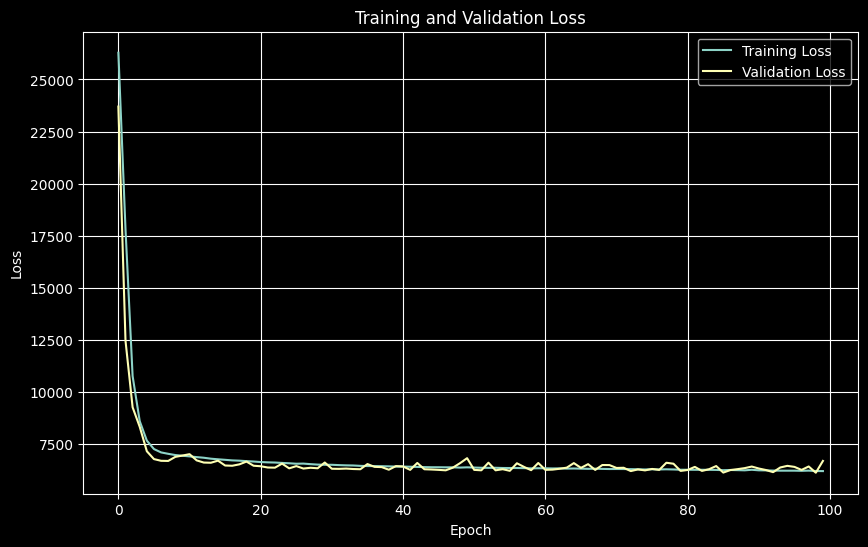

In [12]:
file_names = os.listdir("../Processed-Data/Horse-Results/")
file_paths = list(map(lambda x: "../Processed-Data/Horse-Results/" + x, file_names))
train_paths, test_paths = train_test_split(file_paths, test_size=0.3)
train_paths, val_paths = train_test_split(train_paths, test_size=0.2)

# カスタムデータセットのインスタンス化
train_dataset = TimeSeriesDataset(train_paths)
val_dataset = TimeSeriesDataset(val_paths)
test_dataset = TimeSeriesDataset(test_paths)

# データローダーの設定
batch_size = 32
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

"""
最適なハイパーパラメータ:{
    'lr': 4.6214697747393665e-05,
    'hidden_dim': 56,
    'latent_dim': 37,
    'num_layers': 8,
    'dropout': 0.25954105524890514}  
最適な試行の値: 24820.744140625
"""
# GPUが使える場合はGPU上で動かす
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"training to {device}")
# モデルのインスタンス化
model = AutoEncoder(
    input_dim=67,
    hidden_dim=56,
    latent_dim=37,
    num_layers=8,
    dropout=0.25954105524890514,
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=4.6214697747393665e-05)

# エポック数 20エポックで約10分
num_epochs = 100
# 評価を行うエポック数
eval_interval = 10

# 誤差を記録するリスト
train_losses = []
val_losses = []

# 訓練
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        input_data = batch["input"].to(device)
        optimizer.zero_grad()
        recon_batch = model(input_data)
        loss = ae_loss(recon_batch, input_data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    # エポックごとの平均誤差を計算
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # 一定のエポック数ごとに検証データセットでモデルを評価
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_batch in val_loader:
            val_input = val_batch["input"].to(device)
            recon_batch = model(val_input)
            loss = ae_loss(recon_batch, val_input)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    if epoch % eval_interval == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

# 学習曲線をプロット
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_losses, label="Training Loss")
plt.plot(range(num_epochs), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
model.eval()
test_loss = 0
with torch.no_grad():
    for test_batch in test_loader:
        test_input = test_batch["input"].to(device)
        recon_batch = model(test_input)
        loss = ae_loss(recon_batch, test_input)
        test_loss += loss.item()

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss}")

Test Loss: 6680.99185058991


In [14]:
model.eval()
test_df = pd.read_pickle("../Processed-Data/Horse-Results/2011101814.pkl")
test_df = test_df.iloc[:].astype("float32")
# データフレームをテンソルに変換してGPUに転送
data = torch.tensor(test_df.values, dtype=torch.float32).unsqueeze(0).to(device)

# 潜在変数の取得
with torch.no_grad():
    encoded = model.get_latent_val(data)

print(f"入力データサイズ: {data.size()}")
print(f"潜在変数サイズ: {encoded.size()}")
print("\n潜在変数:")
print(encoded.cpu().numpy())

入力データサイズ: torch.Size([1, 44, 67])
潜在変数サイズ: torch.Size([1, 37])

潜在変数:
[[-0.6031361  -0.41373312 -0.07094935  1.0170487  -0.07658499  0.03957762
  -0.40517583 -0.4399286  -0.7719066  -0.05634143  0.51706153  1.2585212
   1.1883372   0.89504516 -0.55131894 -1.0807186   1.4251518  -1.3181621
   0.26893717 -0.8097326  -0.7210528  -0.541371   -1.4630766  -0.9171215
  -0.32020655  1.138465    0.16784808  0.89805824 -0.62369126  0.29323277
  -0.06836507 -0.23196848  0.597075   -0.21393116 -0.8040468  -0.7157359
  -0.01877082]]


#### 保存


In [15]:
torch.save(model.state_dict(), "../models/v2/horse_result_AE.pth")

## 確認(実際に変換してみる)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoder(
    input_dim=67,
    hidden_dim=56,
    latent_dim=37,
    num_layers=8,
    dropout=0.25954105524890514,
).to(device)
model.load_state_dict(torch.load("../models/v2/horse_result_AE.pth"))
model.eval()
test_df = pd.read_pickle("../Processed-Data/Horse-Results/2011101814.pkl")
test_df = test_df.iloc[:].astype("float32")
# データフレームをテンソルに変換してGPUに転送
data = torch.tensor(test_df.values, dtype=torch.float32).unsqueeze(0).to(device)
# 潜在変数の取得
with torch.no_grad():
    encoded = model.get_latent_val(data)
print(f"入力データサイズ: {data.size()}")
print(f"潜在変数サイズ: {encoded.size()}")
print("\n潜在変数:")
print(encoded.cpu().numpy())

入力データサイズ: torch.Size([1, 44, 67])
潜在変数サイズ: torch.Size([1, 37])

潜在変数:
[[-0.6031361  -0.41373312 -0.07094935  1.0170487  -0.07658499  0.03957762
  -0.40517583 -0.4399286  -0.7719066  -0.05634143  0.51706153  1.2585212
   1.1883372   0.89504516 -0.55131894 -1.0807186   1.4251518  -1.3181621
   0.26893717 -0.8097326  -0.7210528  -0.541371   -1.4630766  -0.9171215
  -0.32020655  1.138465    0.16784808  0.89805824 -0.62369126  0.29323277
  -0.06836507 -0.23196848  0.597075   -0.21393116 -0.8040468  -0.7157359
  -0.01877082]]
